## Phase 4 : Entraînement et optimisation des modèles : Tester plusieurs algorithmes de classification et optimiser leurs hyperparamètres.

### Configuration 

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle

DATA_PATH = "../data/"
CLEAN_FOR_TRAINING = DATA_PATH + "processed/data_clean_for_training.csv"
TEST_DATA = DATA_PATH + "processed/data_for_test.csv"
PICKLE_PATH = "../outputs/pickle/"
TRAINING_FILE = PICKLE_PATH + "training_data.pkl"
ENCODER_FILE = PICKLE_PATH + "encoders_config.pkl"

In [3]:
df = pd.read_csv(filepath_or_buffer=CLEAN_FOR_TRAINING, sep=",", header=0)

### Séparation des données cible et explicative

In [4]:
target = df["Loan_Status"]

In [99]:
log_columns = [col for col in df.columns if "_Log" in col]
original_columns = [col for col in df.columns if "_Log" not in col and f"{col}_Log" not in log_columns]

# Supprimer 'Loan_ID' de la liste des colonnes originales
columns_to_use = [col for col in (original_columns + log_columns) if col != "Loan_ID" and col != "Loan_Status"]

features =  df[columns_to_use]

### Division des colonnes

In [101]:
from sklearn.model_selection import train_test_split

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=42)


### Standardisation des valeurs explicatives (optionnel)

In [102]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
features_train_standard = scaler.fit_transform(features_train)
features_test_standard = scaler.transform(features_test)

### Validation simple

In [116]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_score

# Installer XGBoost si nécessaire
try:
    from xgboost import XGBClassifier
    xgb_available = True
except ImportError:
    xgb_available = False
    print("XGBoost non disponible. Installez-le avec 'pip install xgboost' pour l'utiliser.")


# Liste des modèles
models_standard = {
    "Logistic Regression": LogisticRegression(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "SVM": SVC(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Naive Bayes": GaussianNB(),
}

results = []

for name, model in models_standard.items():
    # Entraîner le modèle
    model.fit(features_train_standard, target_train)
    # Prédire les résultats
    target_pred = model.predict(features_test_standard)
    # Calculer la précision
    precision = precision_score(target_test, target_pred, average="weighted")
    results.append((name, precision))
    print(f"{name} Précision: {precision:.4f}")

# Résultats consolidés
print("\nRésultats finaux :")
for name, precision in results:
    print(f"{name}: {precision:.4f}")

Logistic Regression Précision: 0.8257
K-Nearest Neighbors Précision: 0.6611
SVM Précision: 0.8046
Decision Tree Précision: 0.7057
Random Forest Précision: 0.7200
Gradient Boosting Précision: 0.7729
Naive Bayes Précision: 0.8447

Résultats finaux :
Logistic Regression: 0.8257
K-Nearest Neighbors: 0.6611
SVM: 0.8046
Decision Tree: 0.7057
Random Forest: 0.7200
Gradient Boosting: 0.7729
Naive Bayes: 0.8447


### Validation croisée

##### a. K-fold

In [117]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

results = []
for name, model in models_standard.items():
    # Cross-validation avec scoring F1 et précision
    precision_scores = cross_val_score(model, features_train, target_train, cv=5, scoring=make_scorer(precision_score, zero_division=1))
    results.append({
        "Model": name,
        "Mean Precision": precision_scores.mean(),
    })
    
results

c:\Users\Utilisateur\OneDrive\Documents\Simplon\Brief\16_PredictionBanque\bank-prediction\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Utilisateur\OneDrive\Documents\Simplon\Brief\16_PredictionBanque\bank-prediction\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to

[{'Model': 'Logistic Regression',
  'Mean Precision': np.float64(0.777373519985719)},
 {'Model': 'K-Nearest Neighbors',
  'Mean Precision': np.float64(0.7427782738419322)},
 {'Model': 'SVM', 'Mean Precision': np.float64(0.7023809523809523)},
 {'Model': 'Decision Tree', 'Mean Precision': np.float64(0.7869082502047234)},
 {'Model': 'Random Forest', 'Mean Precision': np.float64(0.7656403539388273)},
 {'Model': 'Gradient Boosting',
  'Mean Precision': np.float64(0.7822672939756041)},
 {'Model': 'Naive Bayes', 'Mean Precision': np.float64(0.7911163185581149)}]

##### b. Leave-One-Out Cross-Validation (LOOCV) 

In [118]:
from sklearn.model_selection import LeaveOneOut

# LOOCV
loo = LeaveOneOut()

results_loocv = []
for name, model in models_standard.items():
    # Cross-validation avec scoring F1 et précision
    precision_scores = cross_val_score(model, features_train_standard, target_train, cv=loo, scoring=make_scorer(precision_score, zero_division=1))
    results_loocv.append({
        "Model": name,
        "Mean Precision": precision_scores.mean(),
    })
    
results_loocv

[{'Model': 'Logistic Regression',
  'Mean Precision': np.float64(0.8166666666666667)},
 {'Model': 'K-Nearest Neighbors',
  'Mean Precision': np.float64(0.8142857142857143)},
 {'Model': 'SVM', 'Mean Precision': np.float64(0.8071428571428572)},
 {'Model': 'Decision Tree', 'Mean Precision': np.float64(0.8476190476190476)},
 {'Model': 'Random Forest', 'Mean Precision': np.float64(0.819047619047619)},
 {'Model': 'Gradient Boosting',
  'Mean Precision': np.float64(0.819047619047619)},
 {'Model': 'Naive Bayes', 'Mean Precision': np.float64(0.8357142857142857)}]

##### c. Stratified k-Fold

In [106]:
from sklearn.model_selection import StratifiedKFold

# Stratified k-Fold avec k=5
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results_skf = []
for name, model in models_standard.items():
    # Cross-validation avec scoring F1 et précision
    precision_scores = cross_val_score(model, features_train_standard, target_train, cv=skf, scoring=make_scorer(precision_score, zero_division=1))
    results_skf.append({
        "Model": name,
        "Mean Precision": precision_scores.mean(),
    })
    
results_skf

[{'Model': 'Logistic Regression',
  'Mean Precision': np.float64(0.7770389881947313)},
 {'Model': 'K-Nearest Neighbors',
  'Mean Precision': np.float64(0.7610758014084918)},
 {'Model': 'SVM', 'Mean Precision': np.float64(0.7800674620138942)},
 {'Model': 'Decision Tree', 'Mean Precision': np.float64(0.775516691415058)},
 {'Model': 'Random Forest', 'Mean Precision': np.float64(0.7673905992602992)},
 {'Model': 'Gradient Boosting',
  'Mean Precision': np.float64(0.7680764611249173)},
 {'Model': 'Naive Bayes', 'Mean Precision': np.float64(0.796593688642869)}]

> J'ai testé plusieurs cross validation. La meilleur précision est Leave-One-Out

Observations :
Meilleur modèle : Naive Bayes

### Optimisation des hyperparamètres

#### GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB

# Définir les hyperparamètres à tester
param_grid = {
    'var_smoothing': [1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4]

}
skf = LeaveOneOut()
# Configurer GridSearchCV
grid_search = GridSearchCV(GaussianNB(), param_grid, cv=loo, scoring=make_scorer(precision_score, zero_division=1))

# Lancer GridSearchCV
grid_search.fit(features_train_standard, target_train)

# Résultats
print(f"Meilleurs paramètres : {grid_search.best_params_}")
print(f"Meilleur score Précision : {grid_search.best_score_:.4f}")

Meilleurs paramètres : {'var_smoothing': 1e-12}
Meilleur score F1 : 0.8357


> L'exécution du gridSearchCV prend 0.2s. Il n'y a aucune intérêts de faire un RandomSearchCV

#### Réentrainement du meilleur modèle

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB

# Définir les hyperparamètres à tester
param_grid = {
    'var_smoothing': [1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4]

}
loo = LeaveOneOut()
# Configurer GridSearchCV
grid_search = GridSearchCV(GaussianNB(), param_grid, cv=loo, scoring=make_scorer(precision_score, zero_division=1))
# Lancer GridSearchCV
grid_search.fit(features_train_standard, target_train)

gaussianNB = GaussianNB(**grid_search.best_params_)
gaussianNB.fit(features_train_standard, target_train)

GaussianNB(var_smoothing=1e-12)

## Phase 5 : Évaluation et interprétation : Évaluer la performance des modèles, analyser l'importance des caractéristiques et interpréter les résultats

### Evaluation des performances globales

#### a. Classification report

In [112]:
from sklearn.metrics import classification_report

# Prédictions sur l'ensemble de test
target_pred = gaussianNB.predict(features_test_standard)

# Rapport de classification
print("Rapport de classification :")
print(classification_report(target_test, target_pred))

Rapport de classification :
              precision    recall  f1-score   support

           0       0.79      0.70      0.74        33
           1       0.87      0.92      0.89        72

    accuracy                           0.85       105
   macro avg       0.83      0.81      0.82       105
weighted avg       0.84      0.85      0.84       105



#### b. Matrice de confusion

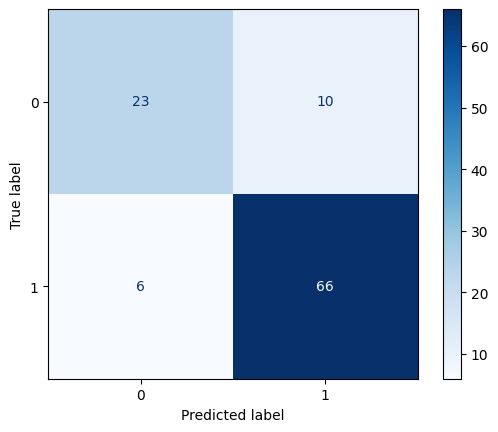

In [113]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Matrice de confusion
cm = confusion_matrix(target_test, target_pred)

# Affichage
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_knn.classes_)
disp.plot(cmap="Blues")

 #### c. Courbe ROC et AUC

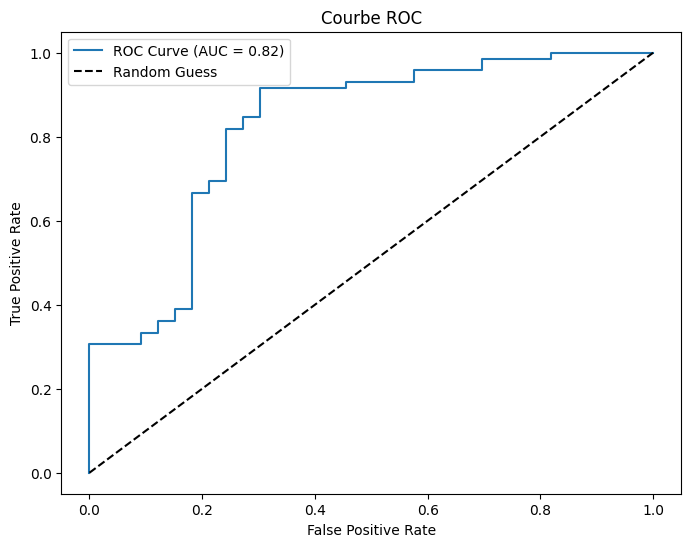

In [115]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Probabilités pour la classe positive
y_proba = gaussianNB.predict_proba(features_test_standard)[:, 1]

# Courbe ROC
fpr, tpr, thresholds = roc_curve(target_test, y_proba)
auc = roc_auc_score(target_test, y_proba)

# Affichage
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Courbe ROC")
plt.legend()
plt.show()

### Conclusion sur le modèle Gaussien
- Points forts :
    - Bonne performance pour la classe majoritaire (classe 1).
    - AUC de 0.82 est solide pour un modèle simple comme Naive Bayes.

- Points faibles : 
    - Faux positifs relativement élevés (10) pour la classe 0.
    - Sensibilité légèrement inférieure pour les exemples de la classe minoritaire.

## Phase 6 : Exportation et utilisation du modèle final : Sauvegarder le modèle sélectionné avec les hyperparamètres optimaux et démontrer comment l'importer pour effectuer des prédictions sur de nouvelles données.

### Sauvegarde

In [120]:
# Sauvegarder le scaler et l'ordre des colonnes dans un fichier pickle
with open(TRAINING_FILE, "wb") as f:
    pickle.dump({"model": gaussianNB, "scaler": scaler, "columns": columns_to_use}, f)

### Exemple d'utilisation

##### a. Chargement des fichiers pickle

In [122]:
# Charger les configurations depuis le fichier pickle
with open(ENCODER_FILE, "rb") as file:
    encoders_config = pickle.load(file)

# Charger le scaler et l'ordre des colonnes
with open(TRAINING_FILE, "rb") as f:
    data = pickle.load(f)

scaler = data["scaler"]
column_order = data["columns"]
model = data["model"]

##### b. Transformation de la donnée à tester

In [150]:
df_test = pd.read_csv(TEST_DATA, sep=",", header=0)

new_data = df_test.sample(frac=1).reset_index(drop=True).head(1)

print(new_data)
# Supprimer Loan_Status
if 'Loan_Status' in encoders_config:
    del encoders_config['Loan_Status']


new_data_encoding = new_data.copy()

# Appliquer les encodages à chaque colonne en fonction du type
for col, config in encoders_config.items():
    if config["type"] == "LabelEncoder":
        # Utiliser l'objet LabelEncoder chargé
        le = config["encoder"]
        new_data_encoding[col] = new_data_encoding[col].apply(lambda x: x if x in le.classes_ else 'unknown')
        new_data_encoding[col] = le.transform(new_data_encoding[col])

    elif config["type"] == "map":
        # Appliquer le mapping manuel
        mapping = config["mapping"]
        new_data_encoding[col] = new_data_encoding[col].map(mapping)
    elif col == "Property_Area":
        # One-Hot Encoding
        # One-Hot Encoding : Ajouter les colonnes nécessaires
        for dummy_col in config["columns"]:
            category = dummy_col.split("_")[-1]
            new_data_encoding[dummy_col] = (new_data_encoding[col] == category).astype(int)
        new_data_encoding = new_data_encoding.drop(columns=[col])


new_data_encoding["ApplicantIncome_Log"] = np.log1p(new_data_encoding["ApplicantIncome"])
new_data_encoding["LoanAmount_Log"] = np.log1p(new_data_encoding["LoanAmount"])
new_data_encoding["CoapplicantIncome_Log"] = np.log1p(new_data_encoding["CoapplicantIncome"])

new_data_encoding = new_data_encoding[column_order]

new_data_standard = scaler.transform(new_data_encoding)

predictions = model.predict(new_data_standard)

predictions = "Y" if predictions[0] == 1 else "N"

print(f"La prédiction est {predictions}")


    Loan_ID Gender Married Dependents Education Self_Employed  \
0  LP001455   Male     Yes          0  Graduate            No   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             3571             1917.0       135.0             360.0   

   Credit_History Property_Area  Loan_Status  
0             1.0         Urban          NaN  
La prédiction est Y
